In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")
    
from preprocess import Preprocessing
from sklearn.model_selection import train_test_split
df = pd.read_excel("Data.xlsx")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11906 entries, 0 to 11905
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   urls        11906 non-null  object 
 1   rooms       11906 non-null  int64  
 2   sq_m        11906 non-null  float64
 3   floor       11709 non-null  float64
 4   floors_all  11640 non-null  float64
 5   area        11906 non-null  object 
 6   year        11906 non-null  object 
 7   price       11906 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 744.2+ KB


#### Almaty house prices

Almaty(Kazakhstan) house prices Dataset is a derived from the popular website [krisha.kz](https://krisha.kz/). The following describes the dataset columns:

**url** - url of the flat</br>  </br>  
**rooms** - number of rooms in the flat </br>  
**sq_m**  - area of the flat in square meter </br>         
**floor** - shows in what floor is the flat  </br>     
**floors_all** - overall floors in the house </br> 
**area** - in what district is house  </br>     
**year** - year built </br>         
**price** - price of the flat </br>      

In [3]:
df.head(2)

,urls,rooms,sq_m,floor,floors_all,area,year,price
0,https://krisha.kz/a/show/677953576,2,76.0,8.0,19.0,Алмалинский,2012,44500000
1,https://krisha.kz/a/show/666789557,2,40.0,2.0,2.0,Ташкентская28,1959,27500000


In [5]:
df = pd.read_excel("Data.xlsx")

df = df.drop(columns=["urls"])

y = df["price"]
X = df.drop(columns=["price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)



# Preprocessing and Data Cleaning

I see 3 main problems in the dataset <br>
1) There are 267 unique elements in the column **area**, although Almaty has only 8 districts <br>
2) The column **year** is of type string and some of the rows have empty string <br>
3) **floor** and **floors_all** has emptry entries

## Problem 1 

There are 267 unique elements in the column "area", although Almaty has only 8 district('Auezovskiy', 'Bostandikskiy', 'Almalinskiy', 'Alatauskiy', 'Medeuskiy', 'Nauryzbaiskiy', 'Turkisibskiy', 'Zhetysuskiy'). So some rows have name of the streets not districts, I will create new class "district9", for all elements, which have street name on area column

In [6]:
len(X_train.area.unique())

267

In [7]:
almaty_areas = ['Ауэзовский', 'Бостандыкский', 'Алмалинский', 'Алатауский', 'Медеуский', 'Наурызбайский', 'Турксибский', 'Жетысуский']
X_train['area'] = X_train['area'].apply(lambda x: x if x in almaty_areas else 'district9')

In [8]:
X_train['area'].value_counts()

Ауэзовский       2187
Бостандыкский    1924
Алмалинский      1405
Алатауский       1112
Медеуский         999
Наурызбайский     981
Турксибский       966
Жетысуский        858
district9         283
Name: area, dtype: int64

## Problem 2

Some entries in column "year" has empty strings, so it cannot be converted to int

In [10]:
try: 
    X_train['year'] = X_train['year'].astype(int)
except ValueError as v:
    print(f'Uppd, I have some probelms with conversion')


Uppd, I have some probelms with conversion


In [11]:
empty_str_ind = []
for i in X_train.index.values:
    try: 
        X_train['year'][i] = int(X_train['year'][i])
    except:
        print(f'{i}-th element exception, string = {X_train.year[i]}')
        empty_str_ind.append(i)

cnt = len(empty_str_ind) 
print(f'number of empty strings = {cnt}, это {100 * cnt/X_train.shape[0]:.3f} % data')

7872-th element exception, string =     
9883-th element exception, string =     
3989-th element exception, string =     
1190-th element exception, string =     
3942-th element exception, string =     
2510-th element exception, string =     
6814-th element exception, string =     
4921-th element exception, string =     
6829-th element exception, string =     
10614-th element exception, string =     
9178-th element exception, string =     
5554-th element exception, string =     
7795-th element exception, string =     
11409-th element exception, string =     
8373-th element exception, string =     
4168-th element exception, string =     
8277-th element exception, string =     
11897-th element exception, string =     
2428-th element exception, string =     
5588-th element exception, string =     
number of empty strings = 20, это 0.187 % data


So there are only 20 such entries, so we can just remove them in the traing set, while in the test set we can replace them with median year in the given district.

In [12]:
X_train.drop(empty_str_ind, inplace = True)
y_train.drop(empty_str_ind, inplace = True)
X_train['year'] = X_train['year'].astype(int)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
#X_val.reset_index(drop=True, inplace=True)
#X_test.reset_index(drop=True, inplace=True)

X_train.groupby(['area'])['year'].median().to_dict()

{'district9': 2014,
 'Алатауский': 2015,
 'Алмалинский': 1983,
 'Ауэзовский': 1986,
 'Бостандыкский': 1989,
 'Жетысуский': 1990,
 'Медеуский': 2007,
 'Наурызбайский': 2019,
 'Турксибский': 1991}

## Пропуски в floors_all и в floor 

Overall we have 235 skipped elements in floors_all and floor

In [16]:
X_train.isna().sum()

rooms           0
sq_m            0
floor         172
floors_all    235
area            0
year            0
dtype: int64

In [17]:
null_data = X_train[X_train.isnull().any(axis=1)]
null_data.shape

(235, 6)

As we can see that there are some relationship between year and floors_all. During USSR mostly 1-5 floored houses had been built, while now we see more multi-storey buildings. We can replace empty floors with floors_all // 2, I think there is no much price difference in the floors [2 - pre last floor]   

[Text(0.5, 1.0, 'floors_all vs year')]

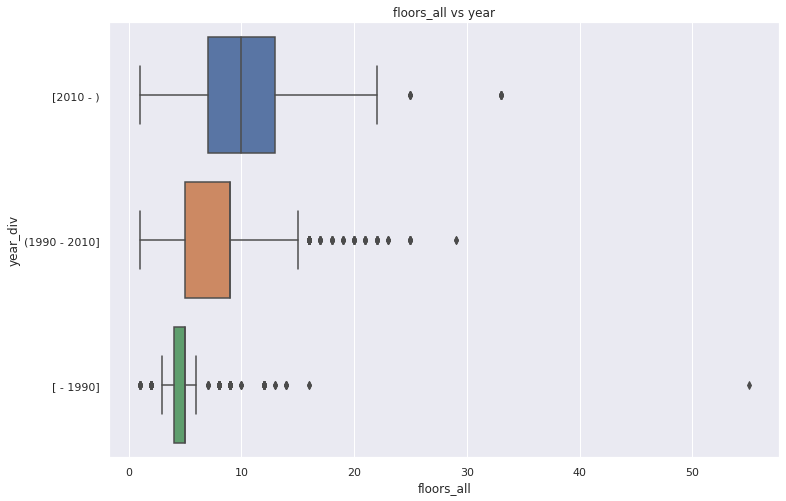

In [18]:
sns.set(rc={'figure.figsize':(12,8)})


year_div = []
for i in range(0, X_train.shape[0]):
    if X_train.iloc[i]['year'] <= 1990: 
        year_div.append('[ - 1990]')
    elif X_train.iloc[i]['year'] > 1990 and X_train.iloc[i]['year'] <= 2010:    
        year_div.append('(1990 - 2010]')
    else:    
        year_div.append('[2010 - )')

X_train['year_div'] = year_div
sns.boxplot(data=X_train, x='floors_all', y='year_div').set(title='floors_all vs year')

So we replace empty elements in floors_all and floor as following: <br>

1. if floor and floors_all both Nan: floors_all - median floors_all by year built, floor = floors_all // 2<br>
2. if only floors_all is Nan: floors_all = floors * 2 <br>
3. if only floor is Nan: floors = floors_all // 2<br>


In [19]:
year_median_floor = X_train.groupby('year_div')['floors_all'].median().to_dict()
X_train.drop(columns=['year_div'], inplace=True)

In [22]:
year_median_floor

{'(1990 - 2010]': 9.0, '[ - 1990]': 5.0, '[2010 - )': 10.0}

In [23]:
import math
def find_floor_all(row):
    if row['year'] <= 1990: 
        floors_all = year_median_floor['[ - 1990]']
    elif 1990 < row['year'] <= 2010:    
        floors_all = year_median_floor['(1990 - 2010]']
    else:    
        floors_all = year_median_floor['[2010 - )']
    return floors_all

indices = []
for i in range(0, X_train.shape[0]):
    if math.isnan(X_train.iloc[i]['floors_all']) and math.isnan(X_train.iloc[i]['floor']):
        indices.append(i)
        X_train['floors_all'].iloc[i] = find_floor_all(X_train.iloc[i])
        X_train['floor'].iloc[i] = X_train['floors_all'].iloc[i] // 2 
    elif math.isnan(X_train.iloc[i]['floors_all']) and not math.isnan(X_train.iloc[i]['floor']):
        indices.append(i)
        X_train['floors_all'].iloc[i] = 2 * X_train['floor'].iloc[i]
    elif math.isnan(X_train.iloc[i]['floor']) and not math.isnan(X_train.iloc[i]['floors_all']):
        indices.append(i)
        if X_train['floors_all'].iloc[i] == 1:
            X_train['floors'].iloc[i] = 1
        else:
            X_train['floor'].iloc[i] = X_train['floors_all'].iloc[i] // 2



In [24]:
X_train.isna().sum()

rooms         0
sq_m          0
floor         0
floors_all    0
area          0
year          0
dtype: int64

## One hot Encoder

We have categorical variable **area**, we will use one_hot_encoder to encode it.

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [26]:
one_hot = OneHotEncoder(drop='first')

In [27]:
one_hot.fit(X_train['area'][:,None])#.toarray()#.shape#.values()

OneHotEncoder(drop='first')

In [28]:
arr = one_hot.transform(X_train['area'][:,None]).toarray()
df_one = pd.DataFrame(arr, columns = ['area1','area2','area3', 'area4','area5','area6', 'area7', 'area8'])
X_train.drop(columns=['area'], inplace=True)
X_train = pd.concat([X_train, df_one], axis=1)

In [29]:
X_train

,rooms,sq_m,floor,floors_all,year,area1,area2,area3,area4,area5,area6,area7,area8
0,3,78.0,5.0,5.0,2021,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,67.0,3.0,6.0,2009,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,15.0,4.0,5.0,1984,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,75.0,8.0,9.0,2020,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,45.0,4.0,4.0,1967,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10690,3,65.2,5.0,5.0,1993,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10691,1,41.0,14.0,14.0,2017,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10692,1,44.3,4.0,5.0,2017,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10693,1,45.0,3.0,9.0,2010,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalize

We should also normalize our data <br>

So overall preprocessing: <br>

1) Streets_to_area - change streets names in **'area'** to "district9" <br>
2) year_to_int - change type of column **year** to int and substitue empty string by median year in a given district.<br>
3) missing entries - replace missing entries <br>
4) one_hot_encoder - one hot encoding of column **area** <br>
5) scaler - normalize the data<br>

all of the steps are in **preprocess.py**

In [15]:
from preprocess import Preprocessing
import pandas as pd


data = Preprocessing(file_name="Data.xlsx", test_size=0.1, random_state=20, save_artefacts=False)

X_train, X_val, X_test = data.preprocess_data()

In [4]:
X_train.shape, X_val.shape, X_test.shape

((8557, 14), (2143, 14), (1191, 14))

# Data Analysis

So, as you can see highest price for houses are in districts Бостандыкский('Bostandykskiy') and Медеуский('Medeuskiy'). <br>

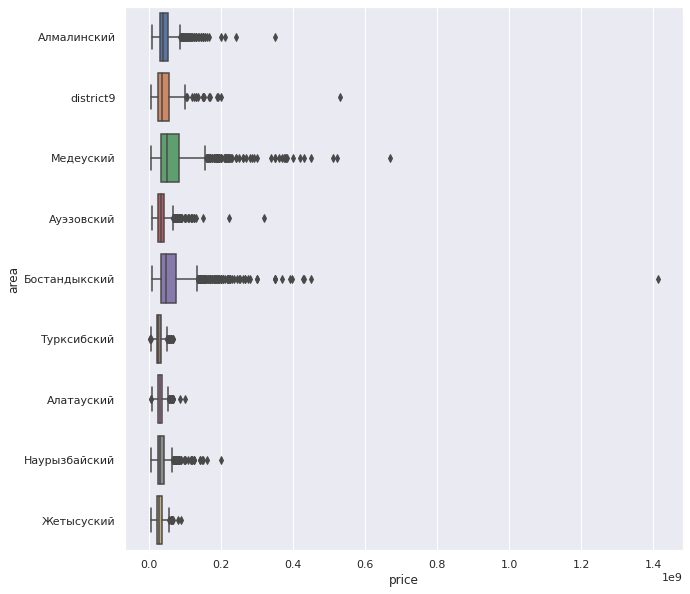

In [3]:
df = pd.read_excel("Data.xlsx")
almaty_areas = ['Ауэзовский', 'Бостандыкский', 'Алмалинский', 'Алатауский', 'Медеуский', 'Наурызбайский', 'Турксибский', 'Жетысуский']
df['area'] = df['area'].apply(lambda x: x if x in almaty_areas else 'district9')

plt.figure(figsize=(10,10))
sns.boxplot(data=df, x="price", y="area")

We see that there is no much difference in number of rooms in 'district9', 'Ауэзовский'(Auezovskiy), 'Турксибский'(Turksibskiy), 'Наурызбайский'(Naurizbaiskiy), 'Жетысуский'(Zhetisuskiy) districts. In 'Алатауский'(Alatauskiy) district, the flats have mostly 1 or 2 rooms, meanwhile in Алмалинский(Almalinskiy), Бостандыский "Bostanskiy", Медеуский "Meduskiy" districts, mostly flats have 2 =< rooms. We also see some outliers like the flats with 10 or more rooms, so we have to deal with them.

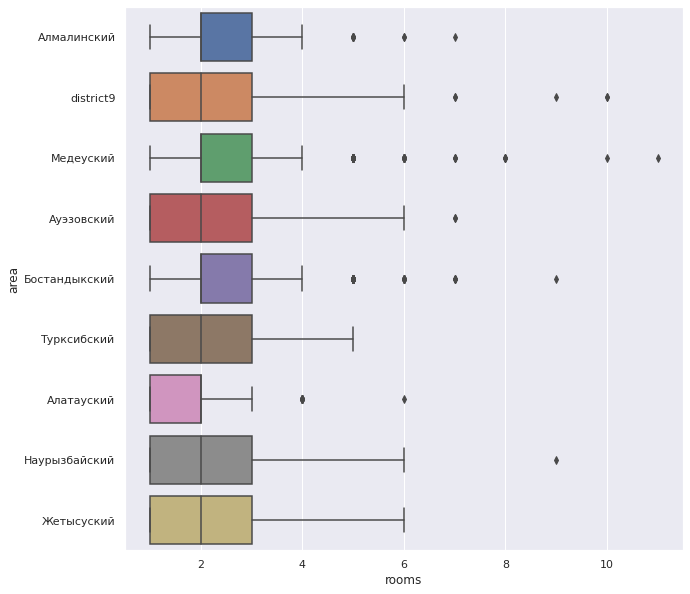

In [4]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x="rooms", y="area")

We see some outliers on sq_m also. For example the flat with 500 sq_m, which is really very rare(at least in Almaty) 

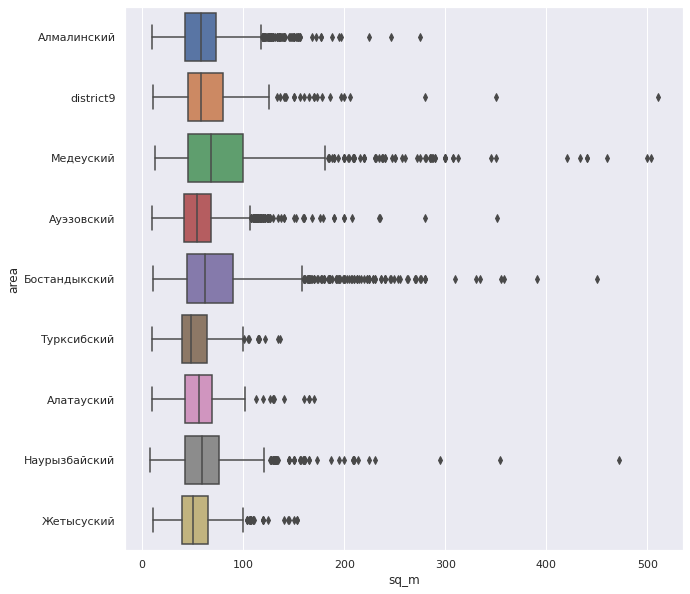

In [5]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x="sq_m", y="area")

In [6]:
X_train = pd.read_csv('./data/train.csv')
y_train = X_train['price']
X_train.drop(columns=['price'], inplace=True)
X_train.shape

(8557, 13)

## Correlation of features with each other
So we see that there is high correaltion between sq_m and rooms, floors_all and floor, floors_all and year. I guess we even may remove rooms, since there is very high correlation with sq_m </br>

All it can be explained logically: more rooms mostly means more sq_m, older the building is less floors_all(this tendency is in ALmaty, during USSR mostly 5 floored buildings have been built, while now more high buildings)



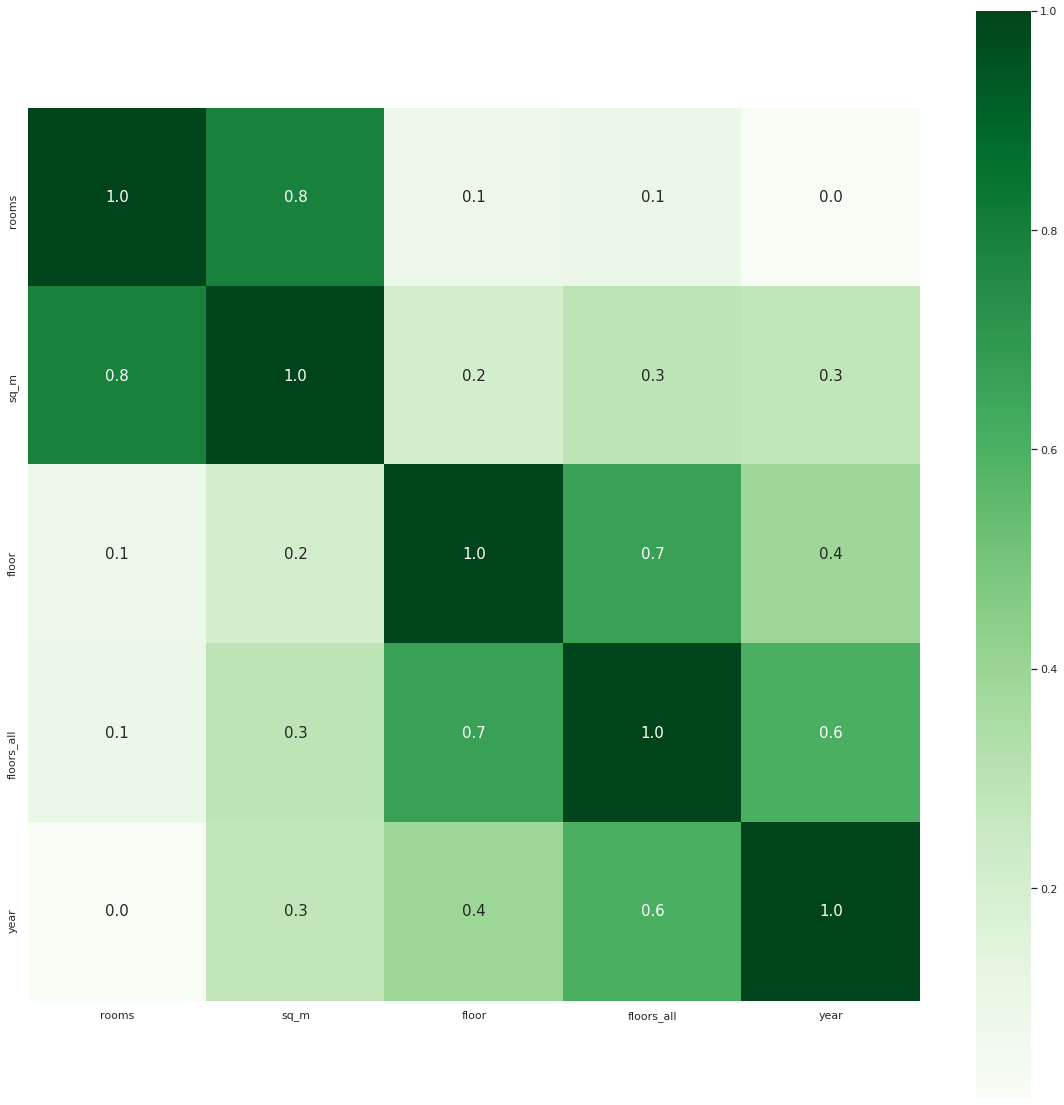

In [7]:
areas = [f'area{i}' for i in range(1, 9)]
cols = [col for col in X_train.columns if col not in areas]
corr = X_train[cols].corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

Text(0, 0.5, 'price')

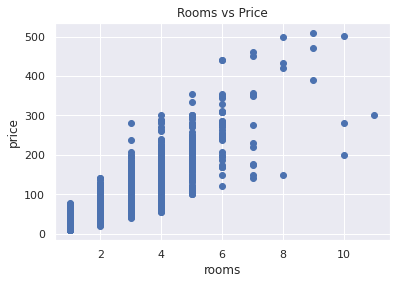

In [8]:
plt.scatter(df['rooms'], df['sq_m'])
plt.title('Rooms vs Price')
plt.xlabel('rooms')
plt.ylabel('price')

## Pearson's Correlation of features with target 

We see high correlation between sq_m and price. So we can say that more sq_m means higher price.

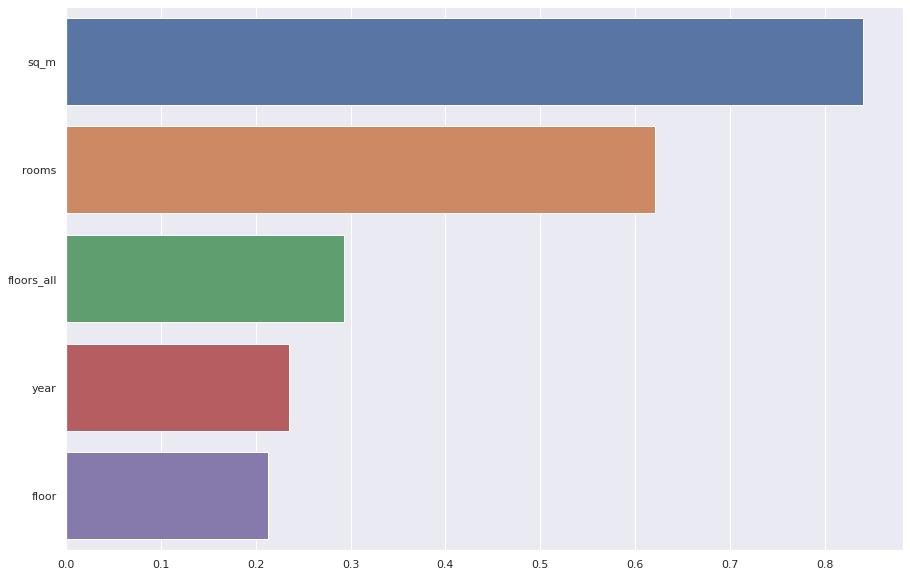

In [9]:
numeric_features = ['rooms', 'sq_m', 'floor', 'floors_all', 'year']
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)


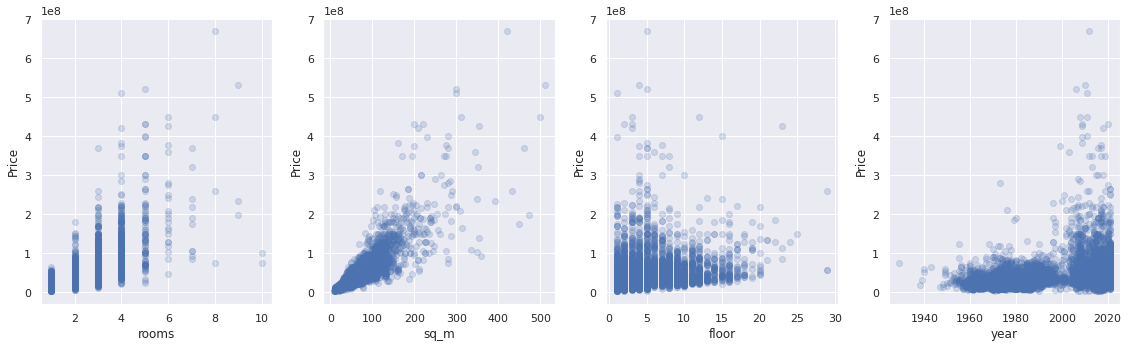

In [10]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=4)
for i, feature in enumerate(["rooms", "sq_m", "floor", "year"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Price")
plt.tight_layout()



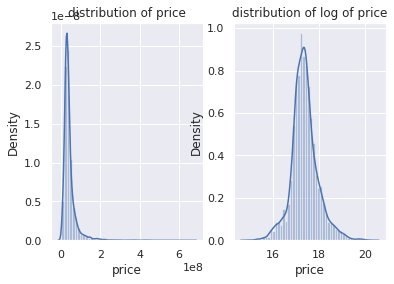

In [11]:
fig, ax =plt.subplots(1,2)
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(y_train, ax=ax[0]).set(title='distribution of price')

sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(np.log(y_train), ax=ax[1]).set(title='distribution of log of price')
fig.show()

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle
import numpy as np
import pandas as pd
target_scaler = pickle.load(open('./utils/target_scaler.pkl','rb'))


alphas = np.logspace(-2, 4, 50)

X_train = pd.read_csv('./data/train_norm.csv')
X_val = pd.read_csv('./data/val_norm.csv')
X_test = pd.read_csv('./data/test_norm.csv')

cols = [col for col in X_train.columns if col != 'rooms']#remove rooms
X_train = X_train[cols]
X_val = X_val[cols]
X_test = X_test[cols]

y_train = X_train['price']
X_train.drop(columns=['price'], inplace=True)
y_val = X_val['price']
X_val.drop(columns=['price'], inplace=True)
y_test = X_test['price']
X_test.drop(columns=['price'], inplace=True)

best_mean_square = float('inf')
best_alpha = 0
rmse_list = []
rmse_train_list = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_train_pred = model.predict(X_train)
    rmse = mean_squared_error(target_scaler.inverse_transform(y_val.to_numpy()[:,None]), target_scaler.inverse_transform(y_pred[:,None]), squared=False)
    rmse_train = mean_squared_error(target_scaler.inverse_transform(y_train.to_numpy()[:,None]), target_scaler.inverse_transform(y_train_pred[:,None]), squared=False)
    print(f'alpha = {alpha:.3f}, val rmse: {rmse:.2f}, train_mse = {rmse_train:.2f}')
    rmse_list.append(rmse)
    rmse_train_list.append(rmse_train)
    if rmse < best_mean_square:
        best_alpha = alpha
        best_mean_square = rmse
 

alpha = 0.010, val rmse: 30629563.37, train_mse = 17940478.17
alpha = 0.013, val rmse: 30629561.57, train_mse = 17940478.17
alpha = 0.018, val rmse: 30629559.19, train_mse = 17940478.17
alpha = 0.023, val rmse: 30629556.02, train_mse = 17940478.17
alpha = 0.031, val rmse: 30629551.83, train_mse = 17940478.17
alpha = 0.041, val rmse: 30629546.27, train_mse = 17940478.17
alpha = 0.054, val rmse: 30629538.90, train_mse = 17940478.18
alpha = 0.072, val rmse: 30629529.14, train_mse = 17940478.19
alpha = 0.095, val rmse: 30629516.19, train_mse = 17940478.22
alpha = 0.126, val rmse: 30629499.05, train_mse = 17940478.25
alpha = 0.168, val rmse: 30629476.33, train_mse = 17940478.32
alpha = 0.222, val rmse: 30629446.23, train_mse = 17940478.43
alpha = 0.295, val rmse: 30629406.37, train_mse = 17940478.63
alpha = 0.391, val rmse: 30629353.61, train_mse = 17940478.99
alpha = 0.518, val rmse: 30629283.79, train_mse = 17940479.60
alpha = 0.687, val rmse: 30629191.46, train_mse = 17940480.67
alpha = 

In [13]:
print(f'best_alpha: {best_alpha}, with val rmse = {best_mean_square:.2f}')

best_alpha: 193.06977288832496, with val rmse = 30587542.92


Text(0, 0.5, 'Rmse')

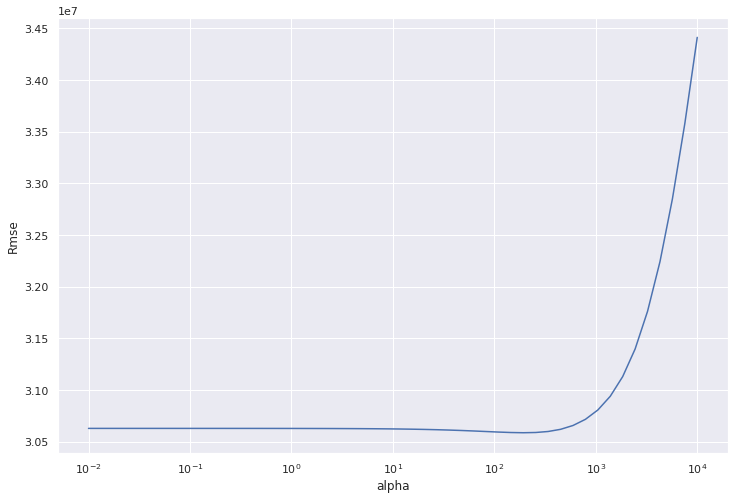

In [14]:
import matplotlib.pyplot as plt
plt.plot(alphas, rmse_list)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Rmse")

In [15]:
model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
       
print("Train RMSE = %.2f" % mean_squared_error(target_scaler.inverse_transform(y_train.to_numpy()[:,None]), target_scaler.inverse_transform(y_train_pred[:,None]), squared=False))
print("Val RMSE = %.2f" % mean_squared_error(target_scaler.inverse_transform(y_val.to_numpy()[:,None]), target_scaler.inverse_transform(y_val_pred[:,None]), squared=False))
print("Test RMSE = %.2f" % mean_squared_error(target_scaler.inverse_transform(y_test.to_numpy()[:,None]), target_scaler.inverse_transform(y_pred[:,None]), squared=False))

Train RMSE = 18001833.13
Val RMSE = 30587542.92
Test RMSE = 16997231.19


In [16]:
from sklearn import metrics


r2_train = metrics.r2_score(target_scaler.inverse_transform(y_train.to_numpy()[:,None]), target_scaler.inverse_transform(y_train_pred[:,None]))
r2_val = metrics.r2_score(target_scaler.inverse_transform(y_val.to_numpy()[:,None]), target_scaler.inverse_transform(y_val_pred[:,None]))
r2_test = metrics.r2_score(target_scaler.inverse_transform(y_test.to_numpy()[:,None]), target_scaler.inverse_transform(y_pred[:,None]))



print(f'R^2 train: {r2_train:.3f}')
print(f'R^2 val: {r2_val:.3f}')
print(f'R^2 test: {r2_test:.3f}')

R^2 train: 0.749
R^2 val: 0.486
R^2 test: 0.741


In [17]:
adj_r2_train = 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
adj_r2_val = 1 - (1-r2_val)*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)
adj_r2_test = 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print(f'Adjusted R^2 train: {adj_r2_train:.3f}')
print(f'Adjusted R^2 train: {adj_r2_val:.3f}')
print(f'Adjusted R^2 train: {adj_r2_test:.3f}')

Adjusted R^2 train: 0.748
Adjusted R^2 train: 0.483
Adjusted R^2 train: 0.738


In [ ]:
#pickle.dump(model, open('./utils/ridge_model.pkl', 'wb'))

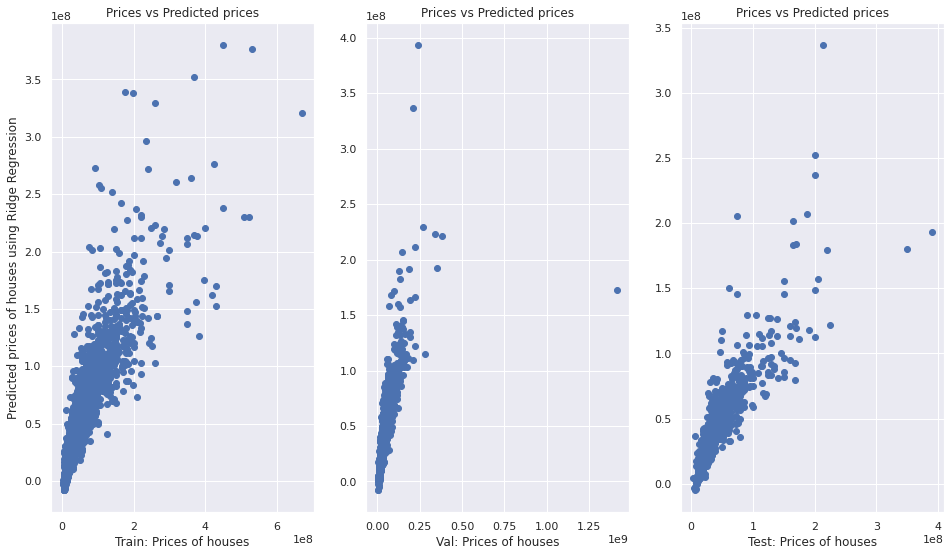

In [18]:
y_train_inverse = target_scaler.inverse_transform(y_train.to_numpy()[:,None])
y_train_pred_inverse = target_scaler.inverse_transform(y_train_pred[:,None])

y_val_inverse = target_scaler.inverse_transform(y_val.to_numpy()[:,None])
y_val_pred_inverse = target_scaler.inverse_transform(y_val_pred[:,None])

y_test_inverse = target_scaler.inverse_transform(y_test.to_numpy()[:,None])
y_test_pred_inverse = target_scaler.inverse_transform(y_pred[:,None])

plt.figure(figsize=(16, 9))
plt.subplot(1, 3, 1)
plt.scatter(y_train_inverse, y_train_pred_inverse)
plt.xlabel("Train: Prices of houses")
plt.ylabel("Predicted prices of houses using Ridge Regression")
plt.title("Prices vs Predicted prices")

plt.subplot(1, 3, 2)
plt.scatter(y_val_inverse, y_val_pred_inverse)
plt.xlabel("Val: Prices of houses")
plt.title("Prices vs Predicted prices")


plt.subplot(1, 3, 3)
plt.scatter(y_test_inverse, y_test_pred_inverse)
plt.xlabel("Test: Prices of houses")
plt.title("Prices vs Predicted prices")

plt.show()

## Simple Xgboost

In [19]:
from xgboost import XGBRegressor

#Create a XGBoost Regressor
reg = XGBRegressor(max_depth=3, n_estimators=30)

# Train the model using the training sets 
reg.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
y_train_pred = reg.predict(X_train)
y_val_pred = reg.predict(X_val)
y_test_pred = reg.predict(X_test)

In [21]:
print("Train RMSE = %.2f" % mean_squared_error(target_scaler.inverse_transform(y_train.to_numpy()[:,None]), target_scaler.inverse_transform(y_train_pred[:,None]), squared=False))
print("Val RMSE = %.2f" % mean_squared_error(target_scaler.inverse_transform(y_val.to_numpy()[:,None]), target_scaler.inverse_transform(y_val_pred[:,None]), squared=False))
print("Test RMSE = %.2f" % mean_squared_error(target_scaler.inverse_transform(y_test.to_numpy()[:,None]), target_scaler.inverse_transform(y_test_pred[:,None]), squared=False))

Train RMSE = 13652043.84
Val RMSE = 29381985.67
Test RMSE = 18120486.88


In [22]:
from sklearn import metrics
import pickle
target_scaler = pickle.load(open('./utils/target_scaler.pkl','rb'))


r2_train = metrics.r2_score(target_scaler.inverse_transform(y_train.to_numpy()[:,None]), target_scaler.inverse_transform(y_train_pred[:,None]))
r2_val = metrics.r2_score(target_scaler.inverse_transform(y_val.to_numpy()[:,None]), target_scaler.inverse_transform(y_val_pred[:,None]))
r2_test = metrics.r2_score(target_scaler.inverse_transform(y_test.to_numpy()[:,None]), target_scaler.inverse_transform(y_test_pred[:,None]))



print(f'R^2 train: {r2_train:.3f}')
print(f'R^2 val: {r2_val:.3f}')
print(f'R^2 test: {r2_test:.3f}')

R^2 train: 0.856
R^2 val: 0.526
R^2 test: 0.705


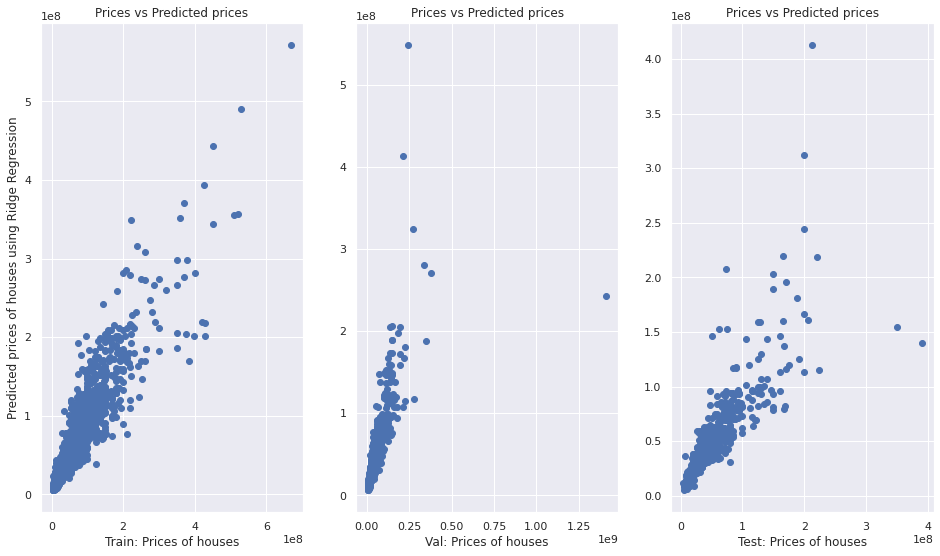

In [23]:
y_train_inverse = target_scaler.inverse_transform(y_train.to_numpy()[:,None])
y_train_pred_inverse = target_scaler.inverse_transform(y_train_pred[:,None])

y_val_inverse = target_scaler.inverse_transform(y_val.to_numpy()[:,None])
y_val_pred_inverse = target_scaler.inverse_transform(y_val_pred[:,None])

y_test_inverse = target_scaler.inverse_transform(y_test.to_numpy()[:,None])
y_test_pred_inverse = target_scaler.inverse_transform(y_test_pred[:,None])

plt.figure(figsize=(16, 9))
plt.subplot(1, 3, 1)
plt.scatter(y_train_inverse, y_train_pred_inverse)
plt.xlabel("Train: Prices of houses")
plt.ylabel("Predicted prices of houses using Ridge Regression")
plt.title("Prices vs Predicted prices")

plt.subplot(1, 3, 2)
plt.scatter(y_val_inverse, y_val_pred_inverse)
plt.xlabel("Val: Prices of houses")
plt.title("Prices vs Predicted prices")


plt.subplot(1, 3, 3)
plt.scatter(y_test_inverse, y_test_pred_inverse)
plt.xlabel("Test: Prices of houses")
plt.title("Prices vs Predicted prices")

plt.show()

In [ ]:
#pickle.dump(reg, open('./utils/xgboost_model.pkl', 'wb'))